In [6]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pathlib import Path

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

data_dir = project_root/"data/results/cnn/"
figures_folder = project_root/"data/figures/cnn/"

# List of pruning range identifiers
variants = ["4down", "34", "23", "12", "05median", "05up"]
base_filename = "pruned_{}.xlsx"

/home/kivi/miniconda3/envs/xnn/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kivi/miniconda3/envs/xnn/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kivi/miniconda3/envs/xnn/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


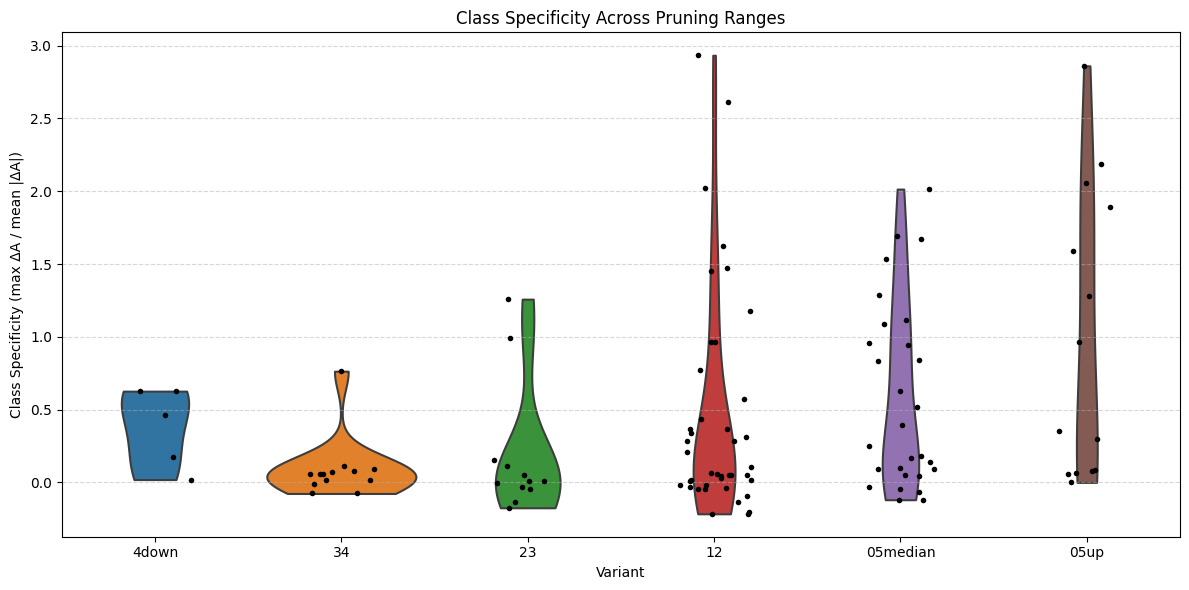

In [ ]:
# Function to compute class specificity
def compute_class_specificity(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_delta = df[delta_cols].max(axis=1)
    mean_abs_delta = df[delta_cols].abs().mean(axis=1)
    return max_delta / mean_abs_delta

# Container for class specificity values
specificity_records = []

# Loop through each file
for variant in variants:
    file_path = os.path.join(data_dir, base_filename.format(variant))
    if not os.path.exists(file_path):
        print(f"Warning: File not found: {file_path}")
        continue

    df = pd.read_excel(file_path)
    class_specificity = compute_class_specificity(df)

    for value in class_specificity.dropna():
        specificity_records.append({
            "Variant": variant,
            "Class Specificity": value
        })

specificity_df = pd.DataFrame(specificity_records)

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Variant", y="Class Specificity", data=specificity_df, inner=None, cut=0)
sns.stripplot(x="Variant", y="Class Specificity", data=specificity_df, color="black", size=4, jitter=0.2)

plt.title("Class Specificity Across Pruning Ranges")
plt.ylabel("Class Specificity (max ΔA / mean |ΔA|)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


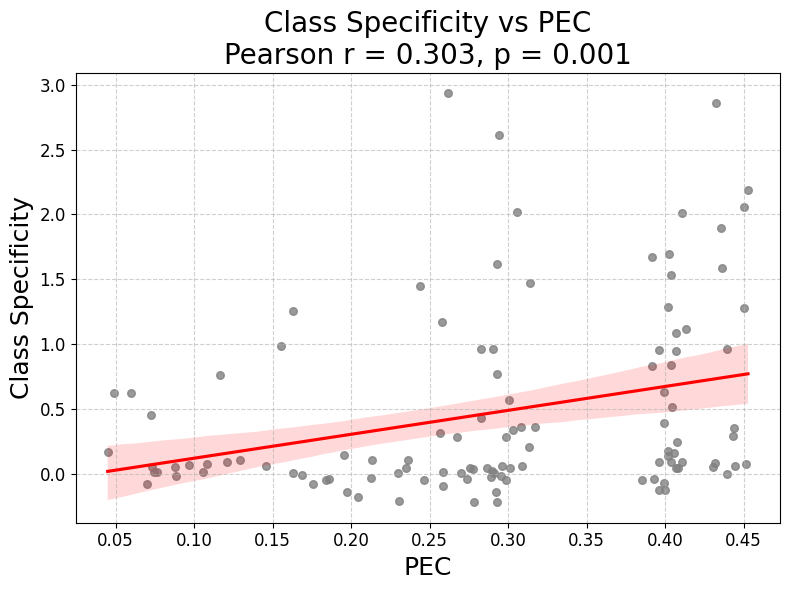

In [15]:
# Function to extract PEC (last float in subnet string)
def extract_pec(subnet_str):
    try:
        floats = re.findall(r"[-+]?\d*\.\d+|\d+", subnet_str)
        return float(floats[-1]) if floats else None
    except Exception:
        return None

# Store all results
records = []

# Process each file
for variant in variants:
    file_path = os.path.join(data_dir, base_filename.format(variant))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_excel(file_path)
    df["Class Specificity"] = compute_class_specificity(df)
    df["PEC"] = df["Subnet"].astype(str).apply(extract_pec)

    for _, row in df.iterrows():
        if pd.notna(row["Class Specificity"]) and pd.notna(row["PEC"]):
            records.append({
                "Variant": variant,
                "Class Specificity": row["Class Specificity"],
                "PEC": row["PEC"]
            })

# Convert to DataFrame
plot_df = pd.DataFrame(records)

# --- PLOTTING ---
plt.figure(figsize=(8, 6))
sns.regplot(data=plot_df, x="PEC", y="Class Specificity", scatter_kws={"s": 30, "color": "grey"}, line_kws={"color": "red"})

# Correlation
corr, p_value = pearsonr(plot_df["PEC"], plot_df["Class Specificity"])
plt.title(f"Class Specificity vs PEC\nPearson r = {corr:.3f}, p = {p_value:.3f}", fontsize=20)
plt.xlabel("PEC", fontsize=18)
plt.ylabel("Class Specificity", fontsize=18)
plt.tick_params(axis='both', labelsize=12) 
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(figures_folder / "pec_vs_class_specificity.png")
plt.show()